# Toy example : Model Choice with $Ma(q)$

## Definition of the model
$$x_{t}=\mu+\epsilon_{t}-\sum_{i=1}^{q} \vartheta_{i} \epsilon_{t-i}$$

In [1]:
import numpy as np

def MAq(t, n_obs=10000, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    s = t.shape[1]
    assert t.shape[0] == batch_size
    random_state = random_state or np.random
    w = random_state.randn(batch_size, n_obs+s)  # i.i.d. sequence ~ N(0,1)
    x = w[:, s:]
    for p in range(s):
        x = x + np.repeat(np.reshape(t[:, p], (batch_size, 1)),
                          n_obs, axis=1)*w[:, (s-p-1):(-p-1)]
    return x

## Priors constraint

For identifiability reasons, 

$$\mathcal{Q}(u)=1-\sum_{i=1}^{q} \vartheta_{i} u^{i}$$

should have only roots outside of the (complex) unity disc. There we sample all $\theta_i$ for $i \lt q$, with $\theta_q$ given.

In [2]:
import math

def generate_maq_priors(q, tq , batch_size=1, random_state=None):
    assert tq.shape[0] == batch_size
    d = q // 2
    if (q % 2) == 0:
        d = d - 1
    random_state = random_state or np.random
    nc = random_state.randint(q, size=batch_size)
    nd = random_state.randint(d, size=batch_size)
    #r = np.random.uniform(min, max, (batch_size, 1))
    genr = np.exp(random_state.dirichlet(
        np.ones(q), batch_size)*np.log(np.abs(1/tq[:,np.newaxis])))
    # genr = genr * randSign(q,(r <= 0),batch_size)
    genr[:, -1] = -genr[:, -1]
    alphas = np.zeros((batch_size, q))
    for i in range(batch_size):
        gen = random_state.uniform(0, math.pi, nd[i])
        d2 = (q - (2*nd[i])) // 2
        if (q % 2) == 0:
            d2 = d2 - 1
        nq = random_state.randint(d2)
        alphas[i, :nd[i]] = gen
        alphas[i, nd[i]:(2*nd[i])] = -gen
        alphas[i, -(2*nq+1):] = -1
    roots = np.zeros((batch_size, q), dtype=complex)
    roots.real = np.cos(alphas)
    roots.imag = np.sin(alphas)
    if (q % 2) != 0:
        roots[:, nc] = -roots[:, nc]
    roots = roots / genr
    assert np.min(np.abs(roots)) > 1, str(roots)  # Prior constraint checking
    poly = np.apply_along_axis(
        np.polynomial.polynomial.polyfromroots, 1, roots).real[:, 1:]
    return poly * np.reshape(tq, (batch_size, 1))

## The observed data
generated by us, of course...

In [3]:
minprior = 1
maxprior = 2
ntree = 500
Ny = 200  # Length of the serie
Ncov = 20  # Maximum of autocorrelation lag
q = 10  # Our chosen q for the observed data
nref = 2000  # Number of expected simulated data from ABC
batchsize = 100

# Generation of the observed data
modsimple = generate_maq_priors(q,np.array([1.3]))
y_obs = MAq(modsimple,Ny)

## Summary statistics 

Autocorrelations, partial autocorrelations (and quantiles) with lag from 1 to $p \ge q$ are recommended for $Ma(q)$ models. We compute 5% and 95% quantiles from the partial autocorrelation (with the `ols` method)

In [4]:
from statsmodels.tsa.stattools import acf, pacf

Ncovmult=4

def pautocorr(x, to=1):
    C = np.zeros((x.shape[0], to*Ncovmult))
    for i in range(x.shape[0]):
        C[i, 0::Ncovmult] = acf(x[i][1:], True, nlags=to, fft=True)[1:]
        res = pacf(x[i][1:], nlags=to, method='ols', alpha=0.05)
        C[i, 1::Ncovmult] = res[0][1:]
        C[i, 2::Ncovmult] = res[1][1:, 0]
        C[i, 3::Ncovmult] = res[1][1:, 1]
    return C

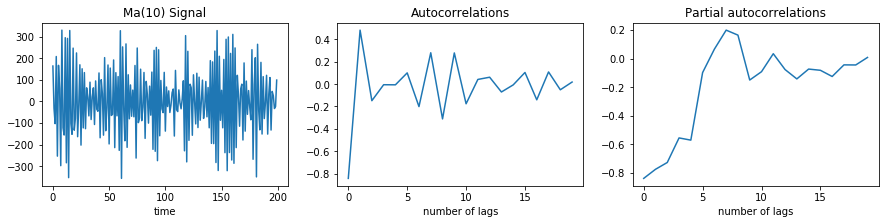

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.subplot(131)
plt.plot(y_obs[0])
plt.title("Ma(10) Signal")
plt.xlabel("time")
plt.subplot(132)
plt.title("Autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,20)[0,0::4]);
plt.subplot(133)
plt.title("Partial autocorrelations")
plt.xlabel("number of lags")
plt.plot(pautocorr(y_obs,20)[0,1::4])
plt.savefig("modelchoice-Signal.svg", format="svg")
#print('Thetas : ', modsimple[0])

## Setting the ABC pipeline

In [6]:
import elfi

We choose 11 models with $q$ ranging from 6 to 16.

In [7]:
qpriors = np.arange(6,17,dtype=np.int)
nclasses = qpriors.shape[0]
maxt = np.max(qpriors)

We penalize the model complexity in the class prior, choosing a linear decrease of probability of class sampling for increasing complexity, here it is just the $q$ class.

In [8]:
class ClassPrior(elfi.Distribution):
    def rvs(n, size=1, random_state=None):
        random_state = random_state or np.random
        return random_state.choice(n,size,p=np.arange(n,0,-1)/(n*(n+1)/2))

### Wrapping priors, custom classes

We have to sample the priors corresponding to each class $q$, with a sampled $\theta_q$ in $[1,2]$ this is the purpose of the `GlobalPrior` wrapper.

In [9]:
class GlobalPrior(elfi.Distribution):
    def rvs(qp, tq, qpriors, size=1, random_state=None):
        class_count = np.zeros(qpriors.shape[0], dtype='int')
        res = np.zeros((size[0], maxt))
        for q in range(qpriors.shape[0]):
            qr = qpriors[q]
            class_count[q] = np.sum(qp == q)
            if (class_count[q] > 0):
                res[qp == q, :qr] = generate_maq_priors(
                    qr, tq[qp == q], class_count[q],random_state)
        return res

Prior declarations and dependances

In [10]:
tq = elfi.Prior('uniform',1,1)
qp = elfi.Prior(ClassPrior, nclasses)
t  = elfi.Prior(GlobalPrior, qp, tq, qpriors)

Final stages, summary stats, simulator and distance

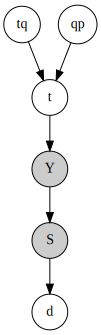

In [11]:
Y = elfi.Simulator(MAq, t, observed=y_obs)
S = elfi.Summary(pautocorr, Y, Ncov)
d = elfi.Distance('euclidean', S)
elfi.draw(d)

In [12]:
elfi.set_client('multiprocessing')
rej = elfi.Rejection(d,batch_size=batchsize,output_names=['S'])

### ABC samping

In [13]:
print('ABC sampling without rejection')
result = rej.sample(nref,quantile=1.0)

ABC sampling without rejection
Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [14]:
print("Class sampled repartition : ")
print([np.sum(result.samples['qp'] == i)/nref for i in range(nclasses)])

Class sampled repartition : 
[0.1705, 0.142, 0.138, 0.129, 0.104, 0.0835, 0.0815, 0.0625, 0.045, 0.027, 0.017]


# AbcRanger, posterior Model Choice

In [15]:
import sys
sys.path.insert(0,'../build')
import pyabcranger

def listvar(prefix, s):
    return [prefix+str(i) for i in range(1, s+1)]

def listvarautocorr(s):
    arr = []
    for i in range(1, s//Ncovmult+1):
        arr.append("acf"+str(i))
        arr.append("pacf"+str(i))
        arr.append("pacfq1_"+str(i))
        arr.append("pacfq2_"+str(i))
    return arr
    
rf = pyabcranger.reftable(
    nref,
    np.histogram(result.samples['qp'],bins=nclasses)[0],
    qpriors,
    listvar('t',maxt),
    listvarautocorr(result.outputs['S'].shape[1]),
    result.outputs['S'],
    result.samples['t'],
    result.samples['qp']+1
)

In [16]:
postres = pyabcranger.modelchoice(rf, S.observed[0],"--ntree "+str(ntree),False)
print('Predicted model  : q =', qpriors[postres.predicted_model])
print('votes : ', postres.votes)
print('Posterior probability : ', postres.post_proba)

///////////////////////////////////////// First forest (training on ABC output)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 879.9 Hz | 1s<0s]  
Computing prediction error ..
///////////////////////////////////////// Second forest (training on error)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 3.1 kHz | 0s<0s]  
Computing prediction error ..
 votes model1 votes model2 votes model3 votes model4 votes model5 votes model6 votes model7 votes model8 votes model9 votes model10 votes model11 selected model post proba
            5            8           46            5          131           19          129           14           95           22           26              5      0.341
Predicted model  : q = 10
votes :  [5, 8, 46, 5, 131, 19, 129, 14, 95, 22, 26]
Posterior probability :  0.34143333333333337


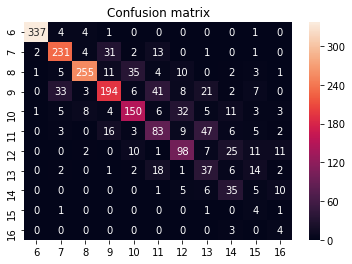

In [17]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(postres.confusion_matrix,qpriors,qpriors)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='d')
plt.title('Confusion matrix');

### Prior oob error (by number of tree)

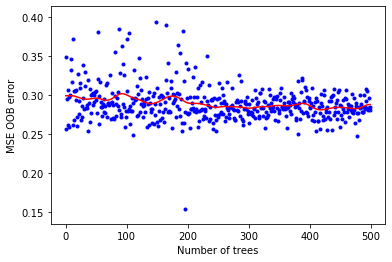

In [18]:
from scipy.ndimage.filters import gaussian_filter1d
ntree_oob_error_smoothed = gaussian_filter1d(postres.ntree_oob_error, sigma=10.0)
plt.figure()
plt.scatter(range(ntree),postres.ntree_oob_error,color='b',marker='.')
plt.plot(ntree_oob_error_smoothed,'r')
#plt.yscale('log')
plt.xlabel('Number of trees')
plt.ylabel('MSE OOB error');

### Variable importance

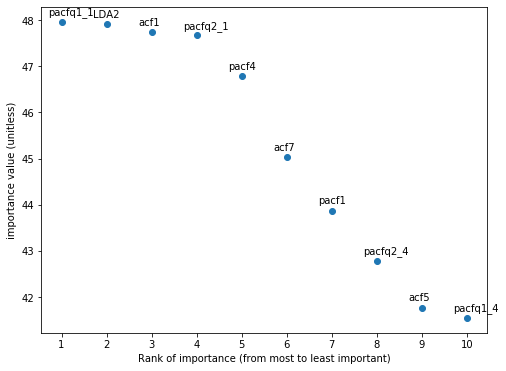

In [24]:
l  = len(postres.variable_importance)
ntop = min(10,l)
#lr = range(l-1,-1,-1)
lr = range(ntop)
labels = [postres.variable_importance[i][0] for i in lr]
imp    = [postres.variable_importance[i][1] for i in lr]
plt.figure(figsize=(8, 6))
plt.scatter(range(1,ntop+1),imp)
plt.xticks(range(1,ntop+1))
for i in range(ntop):
    plt.text(i+0.7,imp[i]+0.15,labels[i])
plt.xlabel('Rank of importance (from most to least important)')
plt.ylabel('importance value (unitless)')
plt.savefig("modelchoice-rank.svg",format="svg")